In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.naive_bayes import MultinomialNB as MNB
from sklearn.metrics import accuracy_score
import math
import numpy as np
from numpy.linalg import qr, norm
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import matplotlib.cm as cm
import urllib

In [2]:
X_train_input = pd.read_csv("20news-bydate/matlab/train.data", delimiter=" ",names = ["docIdx", "wordIdx", "freq"],)
y_train_input = pd.read_csv("20news-bydate/matlab/train.label", names=["labels"])
y_train_input['docIdx'] = y_train_input.index + 1
X_test_input = pd.read_csv("20news-bydate/matlab/test.data", delimiter=" ", names = ["docIdx", "wordIdx", "freq"],)
y_test_input = pd.read_csv("20news-bydate/matlab/test.label", names=["labels"])
y_test_input['docIdx'] = y_test_input.index + 1

In [3]:
word_cnt = X_train_input[["wordIdx", "freq"]].groupby(["wordIdx"], as_index=False).sum().sort_values(by='freq', ascending=False)
word_cnt_filtered = word_cnt[word_cnt['freq']>1000].reset_index()

def preprocessing(X_df, y_df):
    X_df_filtered = X_df.loc[X_df["wordIdx"].isin(word_cnt_filtered.wordIdx)].reset_index(drop=True)
    
    # combine X_* and y_*
    combined_data = X_df_filtered.merge(y_df, on="docIdx", how="inner")
    X = combined_data
    y = combined_data['labels']
    return X,y

In [4]:
X_train, y_train = preprocessing(X_train_input, y_train_input)
X_test, y_test = preprocessing(X_test_input, y_test_input)

In [5]:
def tfidf_matrix(data, words):
    total_doc = len(data)#.groupby(["wordIdx"]))
    idf = []
    for index, group in data.groupby(["wordIdx"], as_index = False).agg(list).iterrows():
        idf.append( math.log ( total_doc / len(group.docIdx) ) )
    X = []
    y = []
    tfidf = []
    for index, group in data.groupby(["docIdx"], as_index = False).agg(list).iterrows():
        x = [0 for i in range(len(words))]
        y.append(group.labels[0])
        for ind in range(len(words)):
            # print(words[ind])
            if words.wordIdx[ind] in group.wordIdx:
                x[ind] = group.freq[group.wordIdx.index(words.wordIdx[ind])]
            # if word[1].wordIdx in group.wordIdx:
            #     x[words.index(word)] = group.freq[group.wordIdx.index(word[1].wordIdx)] / sum(group.freq)
        X.append(x)

    for i in range(len(X)):
        x = []
        total_words_doc = sum(X[i])
        for j in range(len(X[0])):
            x.append(X[i][j] / total_words_doc * idf[j])
        tfidf.append(x)

    # print(y[0])
    return np.array(tfidf), np.array(y)

In [6]:
X_train_tfidf, y_train_tfidf = tfidf_matrix(X_train, word_cnt_filtered)
X_test_tfidf, y_test_tfidf = tfidf_matrix(X_test, word_cnt_filtered)

### 1

In [7]:
mnb = MNB()
mnb.fit(X_train_tfidf, y_train_tfidf)
y_pred = mnb.predict(X_test_tfidf)
accuracy_mnb = accuracy_score(y_pred, y_test_tfidf)
print("Accuracy on test data", accuracy_mnb*100)

Accuracy on test data 40.60250599840043


### 2

In [8]:
lda = LDA()
lda.fit(X_train_tfidf, y_train_tfidf)
y_pred = lda.predict(X_test_tfidf)

In [9]:
accuracy = accuracy_score(y_pred, y_test_tfidf)

In [10]:
print("Accuracy on test data",lda.score(X_test_tfidf, y_test_tfidf) * 100)

Accuracy on test data 39.53612370034658


### 3

In [11]:
phi = X_train_tfidf
phi.shape

(11260, 292)

In [12]:
def orthogonal_iteration(phi, k, terminate=1e-5):
    m,n = phi.shape
    Q = np.random.randn(n, k)
    Q, R = qr(Q)

    while True:
        temp = phi @ Q
        Q_new, R = qr(phi.T @ temp)

        if norm(Q_new - Q) < terminate:
            break

        Q = Q_new
        
    return Q

In [13]:
theta = orthogonal_iteration(phi, 2)
theta.shape

(292, 2)

In [14]:
Y = phi @ theta

In [15]:
# plot Y
Y.shape

(11260, 2)

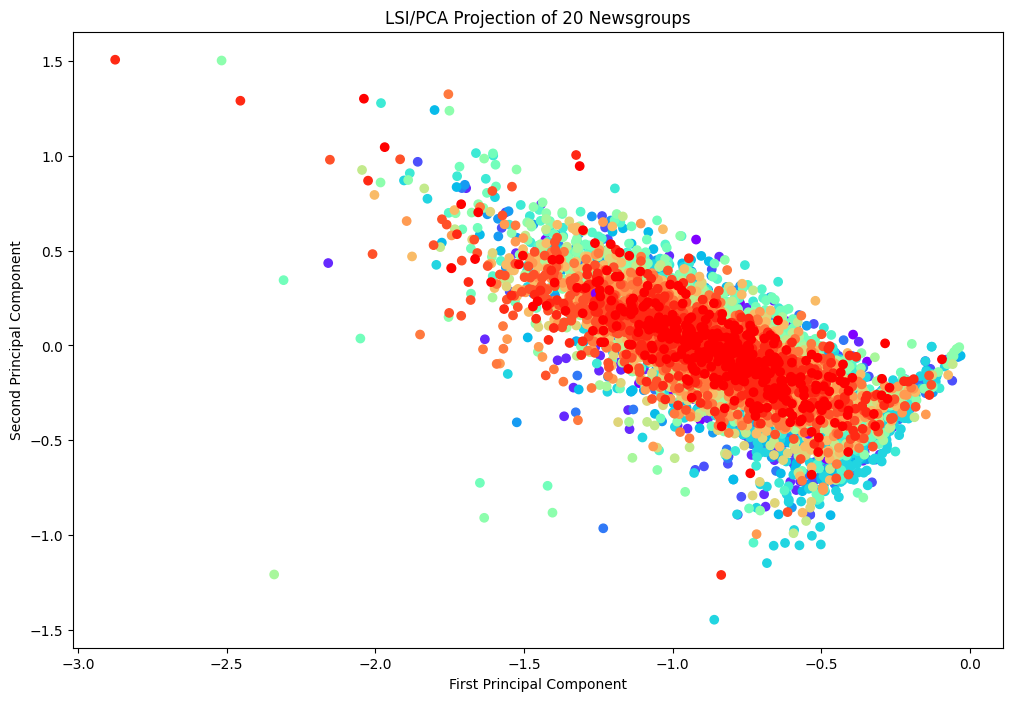

In [16]:
colors = cm.rainbow(np.linspace(0, 1, 20))
plt.figure(figsize=(12, 8))
# for i in range(len(Y)):
#     plt.scatter(Y[i][0], Y[i][1],c=colors[i for j in X_train.groupby(['labels']).agg(set) if i in j])
arr = []
doc_groups = X_train.groupby(['labels']).agg(set)
for i in range(len(Y)):
    flag = 1
    for j,group in doc_groups.iterrows():
        if i+1 in group.docIdx:
            arr.append(j-1)
            flag = 0
            break
    if flag:
        arr.append(0)
plt.scatter(Y[:, 0], Y[:, 1], c=colors[arr])
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('LSI/PCA Projection of 20 Newsgroups')
plt.show()

### 4

In [17]:
phi = orthogonal_iteration(X_train_tfidf, 100)

In [18]:
gmm = GaussianMixture(n_components=20, covariance_type='full')

In [19]:
gmm.fit(phi)

GaussianMixture(n_components=20)

In [20]:
means = gmm.means_

In [21]:
Y = phi @ means.T

In [22]:
means.shape

(20, 100)

In [23]:
phi.shape

(292, 100)

In [24]:
Y.shape

(292, 20)

In [25]:
url = "http://qwone.com/~jason/20Newsgroups/vocabulary.txt"
file = urllib.request.urlopen(url)

word_index_map = {}
i = 0
for line in file:
    word_index_map[i] = line.decode("utf-8").strip()
    i = i + 1

In [26]:
for i in range(20):
    temp = Y[:, i]
    ind1 = temp.argsort()[-10:][::-1]
    print("Top 10 words in cluster", i+1, ":")
    for i in ind1:
        print(word_index_map[i], end=" ")
    print()

Top 10 words in cluster 1 :
feet written san box francisco modified isbn fish laurel telephone 
Top 10 words in cluster 2 :
bumper who aah monks claus that horrors short north fax 
Top 10 words in cluster 3 :
other nd society glenn materialien vertrieb exists feet organizations south 
Top 10 words in cluster 4 :
madison allen lists bay philosophical haught com nd biblical itself 
Top 10 words in cluster 5 :
for americans wrote promoting claus leaving und post der that 
Top 10 words in cluster 6 :
symbol magazine sell copying exists fax wc com many canticle 
Top 10 words in cluster 7 :
tx humanist york aap edition ink humanism immoralities blueprints feet 
Top 10 words in cluster 8 :
resources freethinker canyon they square figmo lists monks absurdities provoking 
Top 10 words in cluster 9 :
alt cameron bible passage lion is wrote publish pp one 
Top 10 words in cluster 10 :
ca one such copying may blueprints who society kingdom lines 
Top 10 words in cluster 11 :
can netcom with to whi

In [27]:
ans = """
Most of the words in the top 10 are common words like can, and, it, is
but some words like hollywood in cluster 10 or organisations in cluster 1
show that the cluster might have new articles about hollywood or organisations
respectively.
"""
print(ans)


Most of the words in the top 10 are common words like can, and, it, is
but some words like hollywood in cluster 10 or organisations in cluster 1
show that the cluster might have new articles about hollywood or organisations
respectively.



In [ ]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups_vectorized
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import csr_matrix
from tqdm import tqdm

def group_l2_norm(theta):
    return np.sqrt(np.sum(theta ** 2, axis=1))

def proximal_group_lasso(theta, gamma_lambda):
    norms = group_l2_norm(theta)
    scaling = np.maximum(0, 1 - gamma_lambda / (norms + 1e-8))  # avoid div by zero
    return (theta.T * scaling).T

def stochastic_proximal_subgradient(X, y, num_classes, num_iters=10**5, lambd=1.0):
    n, m = X.shape
    theta = np.zeros((m, num_classes))
    y = np.array(y)
    
    for t in tqdm(range(1, num_iters + 1)):
        i = np.random.randint(n)
        xi = X[i].toarray().flatten()
        yi = y[i]

        scores = xi @ theta
        margins = scores - scores[yi] + 1
        margins[yi] = -np.inf
        c_star = np.argmax(margins)

        gamma_t = 1.0 / t

        # Subgradient step
        if margins[c_star] > 0:
            theta[:, c_star] += gamma_t * xi
            theta[:, yi] -= gamma_t * xi

        # Proximal step
        theta = proximal_group_lasso(theta, gamma_t * lambd)

    return theta

def predict(X, theta):
    return X @ theta

# Load data
data = fetch_20newsgroups_vectorized(subset='all')
X = data.data  # term frequency (already preprocessed)
y = data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

num_classes = np.max(y) + 1
lambdas = [10, 1, 0.1, 0.01]
accuracies = {}

for lambd in lambdas:
    print(f"Running for λ = {lambd}")
    theta = stochastic_proximal_subgradient(X_train, y_train, num_classes, lambd=lambd)

    preds = predict(X_test, theta)
    y_pred = np.argmax(preds, axis=1)
    acc = np.mean(y_pred == y_test)
    print(f"Accuracy for λ = {lambd}: {acc:.4f}")
    accuracies[lambd] = acc

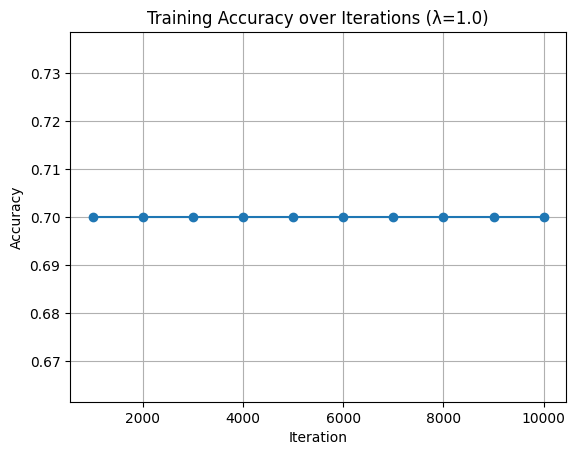

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# Simulated dataset (to replace with real 20 Newsgroups data)
np.random.seed(42)
n_samples, n_features, n_classes = 10, 5, 3
X = np.random.randn(n_samples, n_features)
y = np.random.randint(0, n_classes, size=n_samples)

# Group lasso proximal operator
def group_lasso_proximal_operator(Theta, gamma, lam):
    for j in range(Theta.shape[0]):
        norm = np.linalg.norm(Theta[j, :])
        if norm > 0:
            Theta[j, :] = max(0, 1 - gamma * lam / norm) * Theta[j, :]
    return Theta

# Stochastic proximal subgradient descent for group-lasso SVM
def train_svm_with_group_lasso(X, y, n_classes, lam=1.0, T=10000):
    n_samples, n_features = X.shape
    Theta = np.zeros((n_features, n_classes))
    acc_list = []
    for t in range(1, T+1):
        i = np.random.randint(0, n_samples)
        xi = X[i]
        yi = y[i]
        scores = xi @ Theta
        margins = scores - scores[yi] + 1
        margins[yi] = -np.inf
        c_hat = np.argmax(margins)

        # Subgradient update
        grad = np.zeros_like(Theta)
        grad[:, c_hat] += xi
        grad[:, yi] -= xi
        gamma_t = 1.0 / t
        Theta = Theta - gamma_t * grad

        # Apply proximal operator
        Theta = group_lasso_proximal_operator(Theta, gamma_t, lam)

        # Accuracy every 1000 steps
        if t % 1000 == 0:
            preds = np.argmax(X @ Theta, axis=1)
            acc = np.mean(preds == y)
            acc_list.append((t, acc))

    return Theta, acc_list

# Run with lambda = 1.0
Theta_learned, accuracy_progress = train_svm_with_group_lasso(X, y, n_classes=3, lam=10, T=10000)

# Plot training accuracy
steps, accs = zip(*accuracy_progress)
plt.plot(steps, accs, marker='o')
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Training Accuracy over Iterations (\u03bb=1.0)")
plt.grid(True)
plt.show()